In [37]:
import sys

MI_PATH = "/home/leroyv/Documents/src/thirdparty/mitsuba3/build/python"

if MI_PATH not in sys.path:
    sys.path.insert(0, MI_PATH)
    display(sys.path)

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import mitsuba as mi
import drjit as dr
import seaborn as sns

#dr.set_thread_count(23)
mi.set_variant("scalar_rgb")
mi_logger = mi.Thread.thread().logger()
sns.set_theme(style="ticks", rc={"image.cmap": "viridis"}, context="talk")

In [39]:
import collections
import itertools


def prod(iterable):
    result = 1
    for i in iterable:
        result *= i
    return result


def prime_factors(n):
    i = 2
    while i * i <= n:
        if n % i:
            i += 1
        else:
            n //= i
            yield i

    if n > 1:
        yield n


def get_divisors(n):
    pf = prime_factors(n)

    pf_with_multiplicity = collections.Counter(pf)
    powers = [
        [factor**i for i in range(count + 1)]
        for factor, count in pf_with_multiplicity.items()
    ]
    for prime_power_combo in itertools.product(*powers):
        yield prod(prime_power_combo)


def majorant_grid_factor(n: int, n_min: int = 2, n_max: int = None) -> int:
    """
    Guess an "appropriate" majorant grid resolution factor.

    Parameters
    ----------
    n : int
        Data grid resolution

    n_maj_min : int, optional, default: 2
        Lower bound for the majorant grid resolution.

    n_maj_max : int, optional
        Upper bound for the majorant grid resolution. If unset, defaults to
        ``n - 1``

    Returns
    -------
    n_maj : int
        Majorant grid resolution if a factor was successfully computed.

    divisor : int
        Resolution factor to reach that grid resolution.
    """
    if n_max is None:
        n_max = n - 1

    divisors = sorted(get_divisors(n), reverse=True)

    for divisor in divisors:
        n_maj = n // divisor
        if n_min <= n_maj <= n_max:
            return n_maj, divisor

    return None


majorant_grid_factor(100000, 50, 101)

(50, 2000)

alpha = 50.0
9.643749239819589e-21
tau = 9.022521003967768


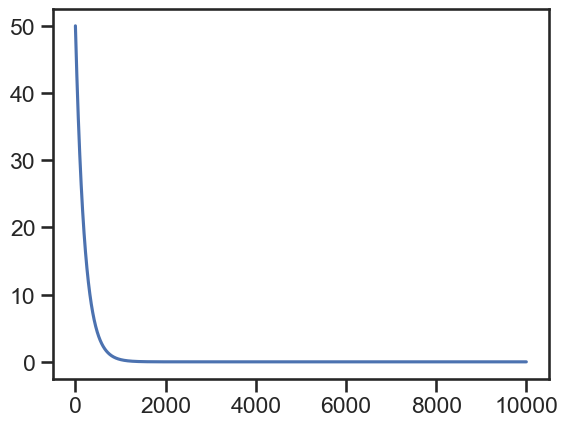

In [40]:
n = 10000  # Number of grid points
zmax = 1.0  # Maximum height
tau = 1.0  # Total Optical thickness
l = zmax / 50  # Typical cutoff height
k = 1 / l  # Decay factor
alpha = tau * k / (1 - np.exp(-k * zmax))  # Pre-exponential factor
print(f"{alpha = }")

z = np.linspace(0, zmax, n)
atmosphere_data = np.reshape(alpha * np.exp(-k * z), (-1, 1, 1))
atmosphere_data = np.broadcast_to(atmosphere_data, (atmosphere_data.shape[0], 3, 3))
print(f"{atmosphere_data.min()}")
plt.plot(atmosphere_data[:, 0, 0].squeeze())

dz = zmax / (n - 1)
print(f"tau = {np.sum(atmosphere_data) * dz}")

In [41]:
scene_dict_ref = {
    "type": "scene",
    # "atmosphere_medium": {
    #     "type": "homogeneous",
    #     "sigma_t": 1.0,
    #     "albedo": 0.5,
    #     "phase": {"type": "rayleigh"},
    # },
    "atmosphere_medium": {
        "type": "heterogeneous",
        "sigma_t": {
            "type": "gridvolume",
            "grid": mi.VolumeGrid(atmosphere_data),
            "to_world": mi.ScalarTransform4f.translate([-0.5, -0.5, -0.5]),
            "accel": False,
        },
        "albedo": 0.5,
        # "majorant_resolution_factor": [1, 1, 100],
        "phase": {"type": "rayleigh"},
    },
    "atmosphere_shape": {
        "type": "cube",
        "interior": {"type": "ref", "id": "atmosphere_medium"},
        "to_world": mi.ScalarTransform4f.translate([0.0, 0.0, 0.0])
        @ mi.ScalarTransform4f.scale(0.5),
        "bsdf": {"type": "null"},
    },
    "surface": {
        "type": "rectangle",
        "to_world": mi.ScalarTransform4f.translate([0.0, 0.0, -0.5])
        @ mi.ScalarTransform4f.scale(0.5),
        "bsdf": {
            "type": "diffuse",
            "reflectance": {
                "type": "checkerboard",
                "to_uv": mi.ScalarTransform4f.scale(2),
            },
        },
    },
    "camera": {
        "type": "perspective",
        "to_world": mi.ScalarTransform4f.look_at(
            origin=[0.0, -2.5, 0.0],
            target=[0.0, 0.0, 0.0],
            up=[0, 0, 1],
        ),
        "sampler": {"type": "independent"},
        "film": {
            "type": "hdrfilm",
            "width": 256,
            "height": 256,
            "rfilter": {"type": "box"},
        },
        "near_clip": 1e-8,
        "far_clip": 1e8,
    },
    "illumination": {
        "type": "directional",
        "direction": [0, -1, -1],
        "irradiance": 5.0,
    },
    "integrator": {"type": "volpath"},
}
scene_ref = mi.load_dict(scene_dict_ref)

scene_dict_maj = scene_dict_ref.copy()
scene_dict_maj["atmosphere_medium"] = {
    **scene_dict_maj["atmosphere_medium"].copy(),
    **{"majorant_resolution_factor": [1, 1, majorant_grid_factor(n, 50, 100)[1]]},
}
scene_maj = mi.load_dict(scene_dict_maj)

2023-08-02 16:52:02 WARN main [HeterogeneousMedium] Majorant supergrid updated (resolution: [3, 3, 50])

In [42]:
mi_logger.set_log_level(mi.LogLevel.Info)

def print_interaction(mei):
    print("MediumInteraction[")
    print(f"  t = {mei.t},")
    print(f"  time = {mei.time},")
    print(f"  wavelengths = {mei.wavelengths},")
    print(f"  p = {mei.p},")
    print(f"  wi = {mei.wi},")
    print(f"  combined_extinction = {mei.combined_extinction},")
    print("]")

medium_ref = scene_ref.shapes()[0].interior_medium()
medium_maj = scene_maj.shapes()[0].interior_medium()

ray = dr.zeros(mi.Ray3f)
ray.o = mi.ScalarPoint3f([0.5, 0.5, 0.0])
ray.d = mi.ScalarVector3f([0, 0, 1])
ray.maxt = 1e5

print(ray)
sample = 0.5
print_interaction(medium_maj.sample_interaction(ray, sample, 0, True))
print_interaction(medium_ref.sample_interaction(ray, sample, 0, True))

Ray3f[
  o = [0.5, 0.5, 0],
  d = [0, 0, 1],
  maxt = 100000,
  time = 0,
]


2023-08-02 16:52:02 INFO main [Medium] desired_tau = 0.693147

2023-08-02 16:52:02 INFO main [GridVolume] ---- i = 0 ----

2023-08-02 16:52:02 INFO main [GridVolume] reached = false

2023-08-02 16:52:02 INFO main [GridVolume] dda_t = 0

2023-08-02 16:52:02 INFO main [GridVolume] dda_tmax = [inf, inf, 0.02]

2023-08-02 16:52:02 INFO main [GridVolume] tau_acc = 0

2023-08-02 16:52:02 INFO main [Medium] sampled_t = inf

MediumInteraction[
  t = inf,
  time = 0.0,
  wavelengths = [],
  p = [nan, nan, inf],
  wi = [-0.0, -0.0, -1.0],
  combined_extinction = [50.0, 50.0, 50.0],
]


2023-08-02 16:52:02 INFO main [Medium] desired_tau = 0.693147

2023-08-02 16:52:02 INFO main [Medium] sampled_t = 0.0138629

MediumInteraction[
  t = inf,
  time = 0.0,
  wavelengths = [],
  p = [0.5, 0.5, 0.013862943276762962],
  wi = [-0.0, -0.0, -1.0],
  combined_extinction = [50.0, 50.0, 50.0],
]


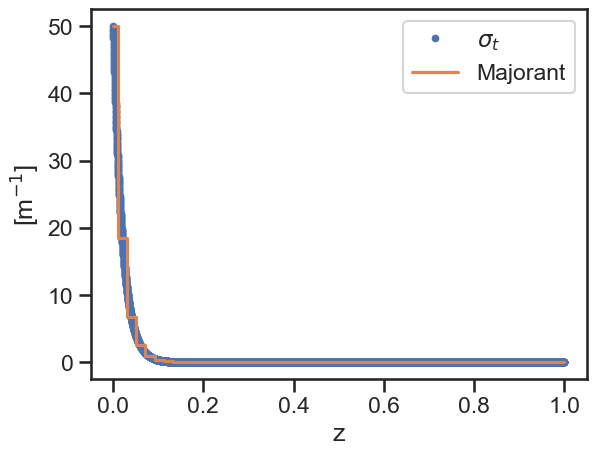

In [43]:
# Visualize scene data
try:
    params = mi.traverse(scene_maj.shapes()[0].interior_medium())
    sigma_t = np.squeeze(params["sigma_t.data"][:, 0, 0])
    majorant = np.squeeze(params["majorant_grid.data"][:, 0, 0])
    plt.plot(
        np.linspace(0, 1, len(sigma_t)), sigma_t, label="$\sigma_t$", ls="", marker="."
    )
    plt.step(np.linspace(0, 1, len(majorant)), majorant, where="mid", label="Majorant")
    plt.xlabel("z")
    plt.ylabel("[m$^{-1}$]")
    plt.legend()
except KeyError:
    print("No majorant grid found")

In [44]:
mi_logger.set_log_level(mi.LogLevel.Warn)

spp = 4096  # For an accurate comparison
spp = 64  # For a quick benchmark

print("Global majorant")
%time arr_ref = mi.render(scene_ref, spp=spp).numpy()
display(mi.Bitmap(arr_ref))
scene_ref.sensors()[0].film().bitmap().convert(
    component_format=mi.Struct.Type.Float32
).write("ref.exr")

print("Local majorant grid")
%time arr_maj = mi.render(scene_maj, spp=spp).numpy()
display(mi.Bitmap(arr_maj))
scene_maj.sensors()[0].film().bitmap().convert(
    component_format=mi.Struct.Type.Float32
).write("maj.exr")


Global majorant
CPU times: user 45 s, sys: 47.9 ms, total: 45 s
Wall time: 6.2 s


Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [256, 256],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

Local majorant grid
CPU times: user 18 s, sys: 25.2 ms, total: 18 s
Wall time: 2.6 s


Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [256, 256],
  srgb_gamma = 0,
  struct = Struct<12>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
  ],
  data = [ 768 KiB of image data ]
]

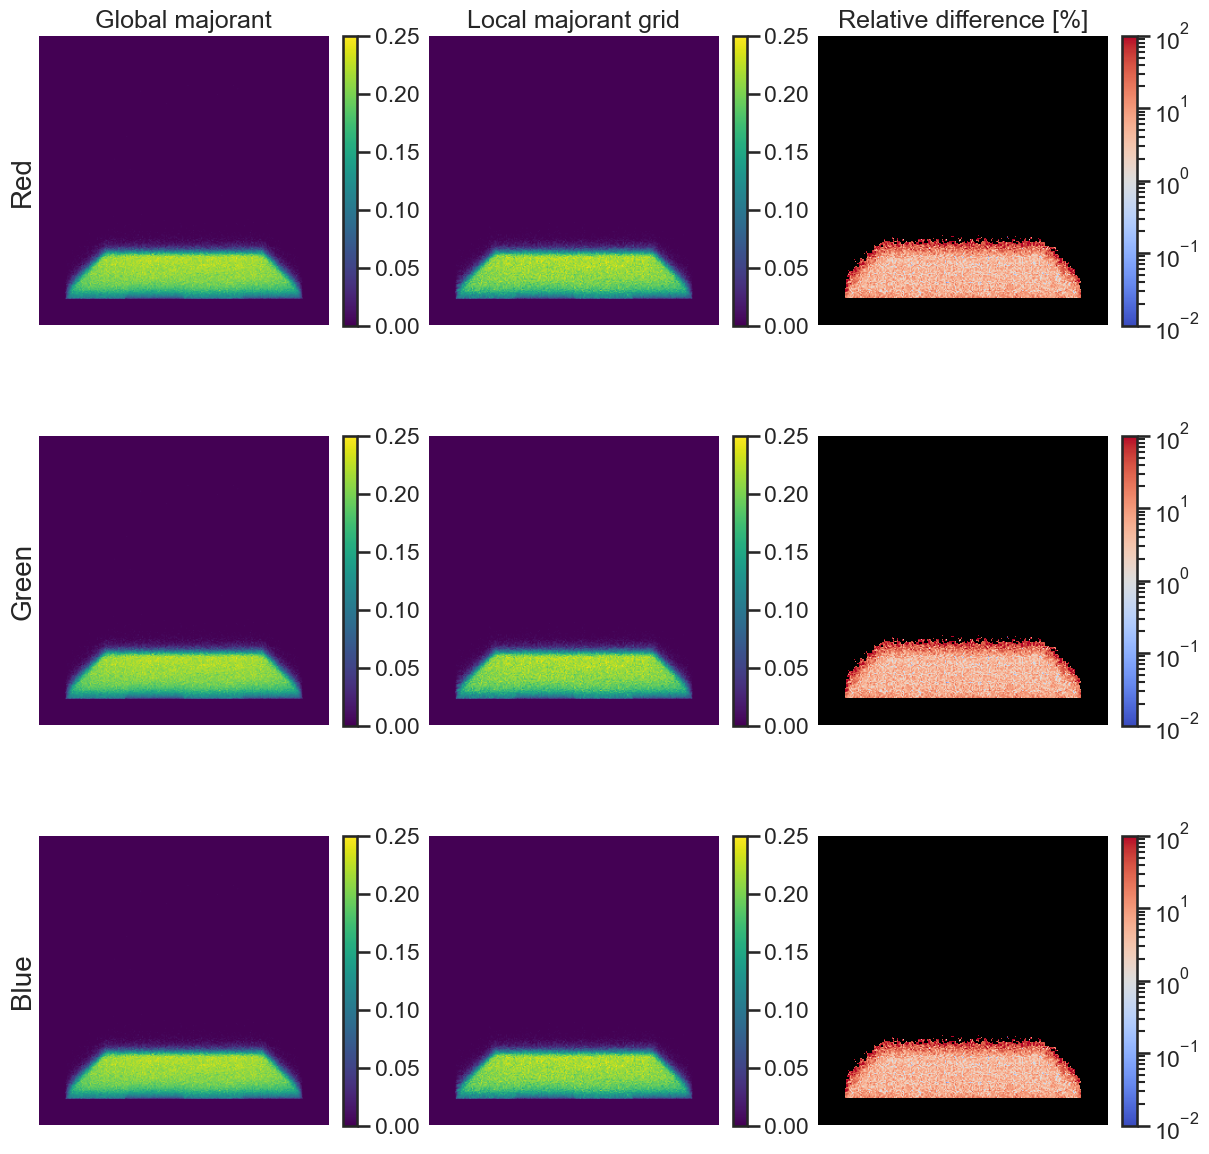

In [45]:
import matplotlib as mpl
import matplotlib.colors as colors

with np.errstate(divide="ignore", invalid="ignore"):
    arr_diff = np.abs((arr_maj - arr_ref) / arr_ref)

arr_diff_masked = np.ma.array(arr_diff, mask=~np.isfinite(arr_diff))
diff_vmin = arr_diff_masked.min()
diff_vmax = arr_diff_masked.max()

fig, axs = plt.subplots(3, 3, figsize=(12, 12), layout="constrained")

for i_row, channel_name in zip(
    range(3),
    ["Red", "Green", "Blue"],
):
    for i_col, data, title, norm, vlim in zip(
        range(3),
        [arr_ref, arr_maj, arr_diff * 100],
        ["Global majorant", "Local majorant grid", "Relative difference [%]"],
        [None, None, "log"],
        [[0, 0.25], [0, 0.25], [1e-2, 1e2]],
    ):
        cmap = mpl.colormaps["viridis" if (i_col < 2) else "coolwarm"]
        cmap.set_bad("black")

        ax = axs[i_row, i_col]
        if i_row == 0:
            ax.set_title(title)
        if i_col == 0:
            ax.annotate(
                channel_name,
                xy=(0, 0.5),
                xytext=(-0.1, 0.5),
                textcoords="axes fraction",
                ha="left",
                va="center",
                rotation=90,
                size=20,
            )

        kwargs = {}

        if norm == "log":
            (vmin, vmax) = vlim if vlim else (diff_vmin, diff_vmax)

            kwargs["norm"] = colors.LogNorm(vmin=vmin, vmax=vmax)

        else:
            if vlim:
                kwargs["vmin"] = vlim[0]
                kwargs["vmax"] = vlim[1]

        ax.axis("off")
        cm = ax.imshow(
            data[:, :, i_row], cmap=cmap, **kwargs
        )
        plt.colorbar(cm, ax=ax, shrink=0.74)